In [6]:
import numpy as np
import matplotlib.pyplot as plt 
import time 
import torch

from core import dqn

In [14]:
def plot_learningcurve(rewards):
    num_players = len(rewards[0])

    # Plot curves for each player in the subplot
    for player in range(num_players):
        plt.plot(rewards[:, player], alpha=0.5, label=f'Player {player + 1}')


    # Display the figure
    plt.title('Learning curves')
    plt.xlabel('Iteration')
    plt.ylabel('Rewards')
    plt.legend()
    plt.show()

Loop: 0
t: 0
Complete


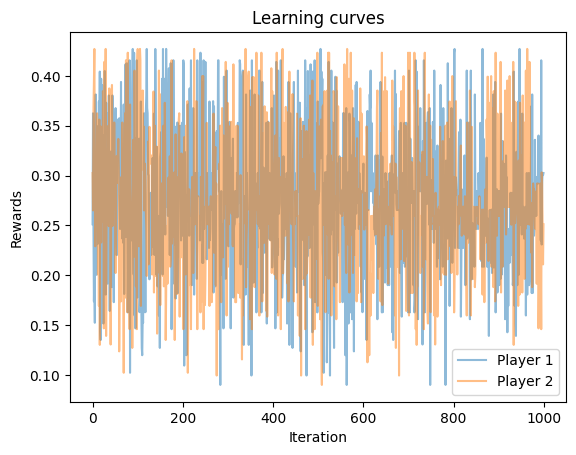

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    nb_iterations = 10000
else:
    nb_iterations = 1000

for loop in range(1):
    print("Loop:", loop)
    agents = [dqn.DeepAgent() for _ in range(2)]
    env = dqn.Env()
    temps = []
    rewards = []
    epsilon = []
    prices = []

    # Initialization of prices p0 (done directly in each agent)
    for agent in agents:
        agent.p = np.random.choice(agent.A)
        
    quantity, state, costs = env([agent.p for agent in agents])
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    
    # Iterative phase
    for t in range(nb_iterations):
        if t % (2*10**5) == 0:
            inter_start = time.time()
            print("t:", t)
        # Actions and state at t+1
        for agent in agents:
            agent.a_ind = agent.get_next_action(state, t)
            agent.p = agent.A[agent.a_ind.item()]
            
        quantity, obs, costs = env([agent.p for agent in agents])
        re = quantity*obs - quantity*costs
        rewards.append(re)
        temps.append(t)
        epsilon.append(agents[0].eps_threshold)
        prices.append([agent.p for agent in agents])
        
        for i, agent in enumerate(agents): 
            agent.reward = torch.tensor([quantity[i]*obs[i] - quantity[i]*costs[i]], device=device)
    
        next_state = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        for agent in agents:
            agent.memory.push(state, agent.a_ind, next_state, agent.reward)

        # Move to the next state
        state = next_state

        for agent in agents: 
            # Perform one step of the optimization (on the policy network)
            agent.optimize_model()

            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            agent.update_network()

rewards = np.vstack(rewards)
print('Complete')
plot_learningcurve(rewards)
plt.ioff()
plt.show()